In [2]:
import pandas as pd
pd.set_option("display.max_rows", 200)

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# 生成A_insulin_regular.csv
- 连接相同速率的用药记录 df_ac_cor
- 异常长度的用药记录
- 异常大小的用药速率

In [6]:
infile = "/public/hanl/jupyter_dir/ir_recommend_v2/00.data/ir_icu_allinsulin.csv"
df_ac = pd.read_csv(infile)
df_ac = df_ac[df_ac["ordercategoryname"] =="01-Drips"]
df_ac = df_ac.loc[:,['stay_id', 'starttime', 'endtime', 'amount', 'rate']]
df_ac["starttime"] = pd.to_datetime(df_ac["starttime"], format='%d/%m/%Y %H:%M:%S')
df_ac["endtime"] = pd.to_datetime(df_ac["endtime"], format='%d/%m/%Y %H:%M:%S')
df_ac= df_ac.sort_values(by=["stay_id", "starttime"])
df_ac.head(2)

,stay_id,starttime,endtime,amount,rate
0,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,3.466667,8.0
1,30000213,2162-06-21 06:06:00,2162-06-21 07:18:00,2.400000,2.0


## 连接相同速率，因换药/护士暂停导致新纪录的用药

In [7]:
tmp_df = pd.DataFrame()
for i,j in df_ac.groupby("stay_id"):
    j["next_rate"] = j["rate"].shift(-1)
    j["d_rate"] = j["next_rate"]-j["rate"]
    tmp_df = pd.concat([tmp_df, j])
df_ac_Add = tmp_df

print(df_ac_Add[df_ac_Add["d_rate"] == 0.0].shape)
print(len(df_ac_Add[df_ac_Add["d_rate"] == 0.0].stay_id.drop_duplicates().tolist()))

(1696, 7)
1303


In [8]:
record_needchange_lst = df_ac_Add[df_ac_Add["d_rate"] == 0.0].stay_id.drop_duplicates().tolist()
print("patient num: " + str(len(record_needchange_lst)))
df_interval_merge = df_ac_Add[df_ac_Add["stay_id"].isin(record_needchange_lst)]

# df_interval_merge指需要合并的病人数据
df_interval_merged = pd.DataFrame(columns=["stay_id", "starttime", "endtime", "amount", "rate"])
for i,j in df_interval_merge.groupby(by="stay_id"):   
    switch=0
    for row in j.itertuples():
        if row.rate == row.next_rate and switch == 0:
            last_stay_id = row.stay_id
            last_starttime = row.starttime
            last_endtime = row.endtime
            last_amount = row.amount
            last_rate = row.rate
            switch = 1
            continue
        if row.rate != row.next_rate:
            if switch == 1 and last_endtime == row.starttime:
                df_interval_merged.loc[len(df_interval_merged)] = [row.stay_id, last_starttime, row.endtime, last_amount+row.amount, row.rate]
                switch = 0
            elif switch == 1 and last_endtime != row.starttime:
                df_interval_merged.loc[len(df_interval_merged)] = [row.stay_id, last_starttime, last_endtime, last_amount, last_rate]
                df_interval_merged.loc[len(df_interval_merged)] = [row.stay_id, row.starttime, row.endtime, row.amount, row.rate]
                switch = 0
            else:
                df_interval_merged.loc[len(df_interval_merged)] = [row.stay_id, row.starttime, row.endtime, row.amount, row.rate]
                
df_interval_merged = df_interval_merged.sort_values(by=["stay_id","starttime"]) 
# df_interval_merged 指合并后的数据

patient num: 1303


## 删除df_ac原来未合并的数据，并添加新的合并后的数据进去

In [10]:
tmp_df = df_ac[~df_ac["stay_id"].isin(record_needchange_lst)]
df_ac_cor = pd.concat([tmp_df, df_interval_merged], axis = 0)
print(df_ac_cor.shape)
print(len(df_ac_cor.stay_id.unique()))

(130642, 5)
11624


## 异常长度的interval 过滤
- 通过数据我们观察到,以某一速率给入insulin regular的时长都在2day以内，故不对数据进行过滤。
- 且rate相同的记录合并并没有在时长上有显著的增加

In [14]:
# 合并前的interval 统计
tmp_df = df_ac
tmp_df["interval"] = (tmp_df["endtime"] - tmp_df["starttime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
tmp_df.sort_values(by = "interval", ascending=False).head(5)

,stay_id,starttime,endtime,amount,rate,interval
240790,39806898,2143-05-23 00:02:00,2143-05-25 12:09:00,60.116670,1.000000,60.116667
18991,30720284,2130-12-21 20:41:00,2130-12-23 22:41:00,100.000005,2.000000,50.000000
38231,31516673,2130-10-22 14:59:00,2130-10-24 15:36:00,24.276001,0.499335,48.616667
59712,32336965,2124-08-12 17:50:00,2124-08-14 16:32:00,46.700002,1.000000,46.700000
43756,31706988,2183-01-12 09:05:00,2183-01-14 06:00:00,89.692612,1.996867,44.916667


In [12]:
# 合并前的interval 统计
tmp_df = df_ac_cor #df_ac_cor是合并相同rate记录dataframe
tmp_df["interval"] = (tmp_df["endtime"] - tmp_df["starttime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
tmp_df.sort_values(by = "interval", ascending=False).head(5)

,stay_id,starttime,endtime,amount,rate,interval
240790,39806898,2143-05-23 00:02:00,2143-05-25 12:09:00,60.116670,1.000000,60.116667
3092,30720284,2130-12-21 20:41:00,2130-12-23 22:41:00,100.000005,2.000000,50.000000
38231,31516673,2130-10-22 14:59:00,2130-10-24 15:36:00,24.276001,0.499335,48.616667
59712,32336965,2124-08-12 17:50:00,2124-08-14 16:32:00,46.700002,1.000000,46.700000
43756,31706988,2183-01-12 09:05:00,2183-01-14 06:00:00,89.692612,1.996867,44.916667


## 异常rate 过滤

- article: Algorithm Maxima for Intravenous Insulin Infusion
The maximum insulin infusion rate in the highest column under the “Conservative” and “Standard Default” algorithms is 14.6 units/h and under the “Aggressive” algorithm is 29.2 unit/h.


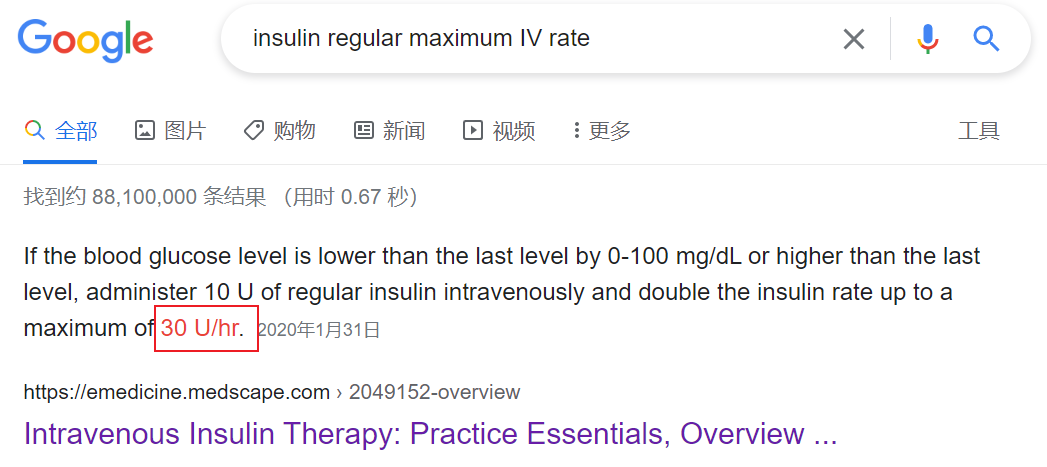

### 异常rate数据统计

/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rate', ylabel='Density'>

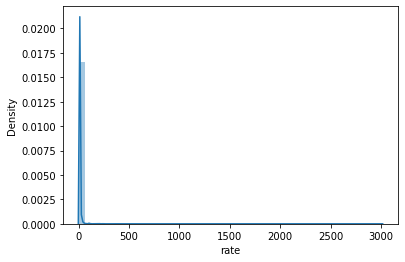

In [52]:
# 经过该图，我们根据分布去除带有潜在异常值的记录
sns.distplot(df_ac_cor["rate"])

/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

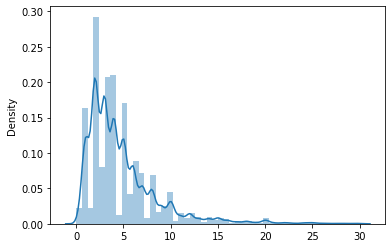

In [53]:
sns.distplot([i for i in df_ac_cor["rate"] if i < 30])

In [17]:
print("记录数：" + str(df_ac.shape[0]))
print("病人人数：" + str(len(df_ac.stay_id.unique())))

# 现去除 rate > 15 unit/hour 记录
print("rate > 15 unit/hour 的记录数：" + str(df_ac_cor[df_ac_cor["rate"] > 15].shape[0]))
print("需要去除的病人人数：" + str(len(df_ac_cor[df_ac_cor["rate"] > 15].stay_id.unique())))
print("需要去除的记录数：" + str(df_ac_cor[df_ac_cor["stay_id"].isin(df_ac_cor[df_ac_cor["rate"] > 15].stay_id.unique())].shape[0]))
df_ac_cor.index = pd.RangeIndex(len(df_ac_cor.index))
df_ac_cor["idx"] = df_ac_cor.index

记录数：130861
病人人数：11624
rate > 15 unit/hour 的记录数：4978
需要去除的病人人数：1116
需要去除的记录数：34791


### 异常rate 涉及的记录过多，删掉损失过多数据，故统计第一个异常rate后的数据与整个数据的时长占比
- 异常rate值后面的记录数：总记录数
- 异常rate前的可用时长：总时长

In [18]:
rate_line = 15
tmp_df = pd.DataFrame(columns=["stay_id","first_M30_rowline", "max_rowline","avil_interval","tot_interval"])
tmp_df2 = pd.DataFrame()

for i,j in df_ac_cor.groupby(by=["stay_id"]):
    j['rowline'] = range(len(j))
    tmp_df2 = pd.concat([tmp_df2,j])
    
    max_rowline = max(j["rowline"])
    avil_interval = sum(j[j["rate"]<=rate_line]["interval"])
    tot_interval = sum(j["interval"])
    if j[j["rate"]>rate_line].shape[0] != 0:
        first_M30_rowline = min(j[j["rate"]>rate_line]["rowline"])
        tmp_df.loc[len(tmp_df)] = [i, first_M30_rowline,max_rowline,avil_interval, tot_interval ]
tmp_df["d_interval"] = tmp_df["tot_interval"] - tmp_df["avil_interval"]
df_rate_ab = tmp_df

/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1 2 18
3 4 23
5 6 23
7 8 29
9 10 33
11 12 18
13 14 30
15 16 31
17 18 19
19 20 17
21 22 18
23 24 11
25 26 14
27 28 5
29 30 12
31 32 13
33 34 13
35 36 13
37 38 9
39 40 6
41 42 5
43 44 5
45 46 13
47 48 8
49 50 4


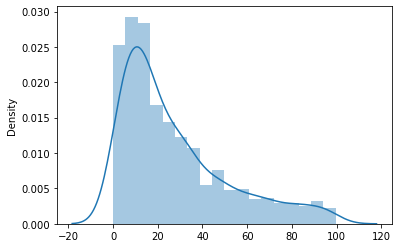

In [19]:
sns.distplot([i for i in df_rate_ab["avil_interval"] if i< 100])

for i in range(1,50,2):
    lst = [n for n in df_rate_ab["avil_interval"] if (n <= i+1) & (n >=i)]
    print(i, i+1, len(lst))

1 2 147
3 4 128
5 6 68
7 8 39
9 10 32
11 12 24
13 14 16
15 16 10
17 18 5
19 20 9


/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


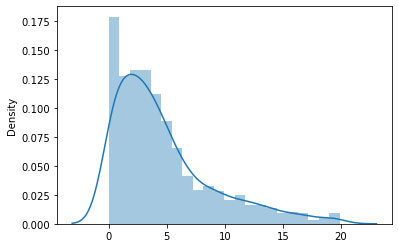

In [20]:
sns.distplot([i for i in df_rate_ab["d_interval"] if i <20])
for i in range(1,20,2):
    lst = [n for n in df_rate_ab["d_interval"] if (n <= i+1) & (n >=i)]
    print(i, i+1, len(lst))

In [22]:
# 根据统计的结果我们认为异常rate后的数据仅占小部分,因此删除异常rate后的interval记录
print("rate前interval总时长， 总时长， rate后的interval总时长（hour）")
print(round(sum(df_rate_ab["avil_interval"]),2),round(sum(df_rate_ab["tot_interval"]),2), round(sum(df_rate_ab["d_interval"]),2))

rate前interval总时长， 总时长， rate后的interval总时长（hour）
60610.43 67178.7 6568.27


#### 删除异常rate后的interval记录

In [23]:
tmp_df = pd.DataFrame()
for i,j in df_ac_cor.groupby(by=["stay_id"]):
    j['rowline'] = range(len(j))
    
    if j[j["rate"]>15].shape[0] != 0:
        first_M30_rowline = min(j[j["rate"]>15]["rowline"])
        j = j[j["rowline"] < first_M30_rowline]
        tmp_df = pd.concat([tmp_df, j])
    else:
        tmp_df = pd.concat([tmp_df, j])
df_ac_c2 = tmp_df
df_ac_c2 = df_ac_c2.drop(["rowline"],axis=1)

## 输出action

In [36]:
print(df_ac.shape[0], len(df_ac.stay_id.unique()))
print(df_ac_cor.shape[0], len(df_ac_cor.stay_id.unique()))
print(df_ac_c2.shape[0], len(df_ac_c2.stay_id.unique()))

130861 11624
130642 11624
104547 11576


In [39]:
df_ac_c2 = df_ac_c2.drop(["idx","interval"],axis=1)
df_acf = df_ac_c2
df_acf.to_csv("A_insulin_regular.csv", index= False)
df_acf.head(2)

,stay_id,starttime,endtime,amount,rate
0,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,3.466667,8.0
1,30000213,2162-06-21 06:06:00,2162-06-21 07:18:00,2.400000,2.0


像我们之前考虑的RR中没有glucose就进行了调节等这样的问题暂不考虑

# 形成60min 窗口(结合action)
- 若区间大于60min，每次输入一个区间，按30min的窗口划动，最后一个窗口从结束时间向前倒推60min
- 若区间小于60min，以该区间为一个窗口


In [ ]:
df_ac = pd.read_csv("A_insulin_regular.csv")
df_ac["starttime"] = pd.to_datetime(df_ac["starttime"])
df_ac["endtime"] = pd.to_datetime(df_ac["endtime"])
df_ac = df_ac.sort_values(by=["stay_id", "starttime"])

In [58]:
df_ac

,stay_id,starttime,endtime,amount,rate
0,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,3.466667,8.00000
1,30000213,2162-06-21 06:06:00,2162-06-21 07:18:00,2.400000,2.00000
2,30001148,2156-08-30 19:15:00,2156-08-30 22:00:00,5.500000,2.00000
3,30002415,2126-12-17 11:59:00,2126-12-17 15:16:00,9.850000,3.00000
4,30002415,2126-12-17 15:16:00,2126-12-17 16:19:00,4.200777,4.00074
...,...,...,...,...,...
104542,39999552,2186-07-17 18:49:00,2186-07-17 20:18:00,5.933334,4.00000
104543,39999552,2186-07-17 20:18:00,2186-07-17 20:25:00,0.349937,2.99946
104544,39999552,2186-07-17 20:25:00,2186-07-17 23:19:00,2.899478,0.99982
104545,39999552,2186-07-17 23:19:00,2186-07-18 04:18:00,9.964872,1.99964


In [54]:
def split_time_ranges(from_time, to_time, frequency,a,b,c):
    
    from_time, to_time = pd.to_datetime(from_time), pd.to_datetime(to_time)
    time_range = list(pd.date_range(from_time, to_time, freq='%sS' % frequency))
    if to_time not in time_range:
        time_range.append(to_time)
    time_range = [item.strftime("%Y-%m-%d %H:%M:%S") for item in time_range]
    #time_ranges = []
    tmp_df = pd.DataFrame(columns=['stay_id', 'starttime', 'endtime', 'amount', 'rate'])
    for item in time_range:
        f_time = item
        t_time = (datetime.datetime.strptime(item, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(seconds=frequency))
        if t_time >= to_time:
            t_time = to_time.strftime("%Y-%m-%d %H:%M:%S")
            #time_ranges.append([f_time, t_time])
            tmp_df.loc[len(tmp_df)] = [a, f_time, t_time, b, c]
            break
        tmp_df.loc[len(tmp_df)] = [a, f_time, t_time.strftime("%Y-%m-%d %H:%M:%S"), b, c]
       # time_ranges.append([f_time, t_time.strftime("%Y-%m-%d %H:%M:%S")])
    return tmp_df #time_ranges

In [55]:
# 每次运行前注意
winsize = 60
df_ac_winf = df_ac 
out_df = pd.DataFrame()
for row in df_ac_winf.itertuples():
    from_time = row.starttime
    to_time = row.endtime
    frequency = 60 * 60 * 1  # 1h = 60s * 60min
    a = row.stay_id
    b = row.amount
    c = row.rate
    time_ranges = split_time_ranges(from_time, to_time, frequency, a, b,c )
    time_ranges["endtime"]= pd.to_datetime(time_ranges["endtime"])
    time_ranges["starttime"]= pd.to_datetime(time_ranges["starttime"])
    time_ranges["interval"] = (time_ranges["endtime"] - time_ranges["starttime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist() 
    
    if time_ranges[time_ranges["interval"] < winsize].shape[0] > 0:
        altertime = time_ranges[time_ranges["interval"] < winsize]["starttime"].iloc[0]
        if altertime > from_time:
            altertime = to_time + datetime.timedelta(minutes=-winsize)
            tmp_df = time_ranges[time_ranges["interval"] < winsize]
            tmp_df["starttime"] = altertime
            tmp_df["interval"] = (tmp_df["endtime"] - tmp_df["starttime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
            time_ranges = pd.concat([time_ranges,tmp_df])
            time_ranges = time_ranges[time_ranges["interval"]==winsize]
    out_df = pd.concat([out_df, time_ranges])

out_df["interval"] = (out_df["endtime"] - out_df["starttime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
out_df["amount"] = (out_df["interval"]/60) * out_df["rate"]
#out_df.to_csv("A_IR_win60_notrajid.csv", index=False)
# 40min

In [61]:
df_acf = out_df 
df_acf = df_acf.sort_values(by=["stay_id","starttime"])
df_acf.index = pd.RangeIndex(len(df_acf.index))

In [66]:
# 增加traj_id
out_df = pd.DataFrame()
traj_id_num = 0

for i,j in df_acf.groupby("stay_id"):
    last_endtime = j[0:1]["endtime"].iloc[0]
    bg_idx = j[0:1].index[0]

    for row in j[1:].itertuples():
        if row.starttime > last_endtime:
            ed_idx = row.Index - 1
            tmp_df = j.loc[bg_idx:ed_idx]
            tmp_df["traj_id"] = traj_id_num
            out_df = pd.concat([out_df, tmp_df])
            traj_id_num  += 1
            bg_idx = row.Index
        last_endtime = row.endtime
        
    ed_idx = row.Index - 1
    tmp_df = j.loc[bg_idx:ed_idx+1]
    tmp_df["traj_id"] = traj_id_num
    out_df = pd.concat([out_df, tmp_df])
    traj_id_num  += 1   

for oth in list(set(df_acf.stay_id.unique().tolist()).difference(set(out_df.stay_id.unique().tolist()))):
    tmp_df = df_acf[df_acf["stay_id"] == oth]
    tmp_df["traj_id"] = traj_id_num
    out_df = pd.concat([out_df, tmp_df])
    traj_id_num  += 1

# 大概 1 min

KeyError: "['index'] not found in axis"

In [ ]:
out_df

,stay_id,starttime,endtime,amount,rate,interval,traj_id
106369,33936373,2182-05-23 16:23:00,2182-05-23 17:10:00,7.833333,10.0,47.0,18865


In [97]:
# 得到用药轨迹后，轨迹长度必须大于3h
tmp_df = pd.DataFrame(columns=["traj_id", "bg", "ed", "traj_length"])
for i,j in out_df.groupby("traj_id"):
    j = j.sort_values("starttime")
    bg = j.iloc[:1]["starttime"].tolist()[0]
    ed = j.iloc[-1:]["endtime"].tolist()[0]
    traj_length = (ed-bg)/np.timedelta64(1, 'h')
    tmp_df.loc[len(tmp_df)] = [i, bg,ed, traj_length]
tmp_df.to_csv("traj_length.csv",index=False)

/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


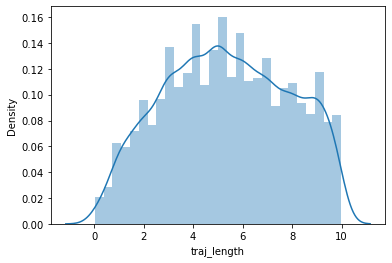

In [111]:
# 过滤轨迹长度小于2h的数据 
# 轨迹峰值为5个小时
sns.distplot(tmp_df[tmp_df["traj_length"]<10]["traj_length"])
traj_lengthM2_lst = tmp_df[tmp_df["traj_length"]>2]["traj_id"].tolist()


In [113]:
out_df = out_df[out_df["traj_id"].isin(traj_lengthM2_lst)]
out_df.to_csv("A_IR_win60.csv",index=False)


In [121]:
len(out_df.stay_id.unique()),len(out_df.traj_id.unique())

(11215, 17617)

# bak bak bak ~~~



# 添加轨迹结束后的2个小时（rate=0）

In [ ]:
# 这步先不用
# 从起始到结束位点，转为窗口格式
# 这一步增加了用药结束后2h
tmp_df = pd.DataFrame(columns=['stay_id', 'starttime', 'endtime', 'amount', 'rate', 'interval'])

for i,j in df_ac.head(100).groupby("stay_id"):
   # bg = j["starttime"].iloc[0] + datetime.timedelta(hours=-6)
    ed = j["endtime"].iloc[-1] + datetime.timedelta(hours=2)
   # tmp_df.loc[len(tmp_df)] = [i, bg, j["starttime"].iloc[0], 0, 0, 0]
    tmp_df.loc[len(tmp_df)] = [i, j["endtime"].iloc[-1], ed, 0, 0, 0]
df_ac_win = pd.concat([tmp_df,df_ac], axis=0)
df_ac_win = df_ac_win.sort_values(by=["stay_id", "starttime"])
print(df_ac.shape, df_ac_win.shape)

In [ ]:
# 从起始到结束位点，转为窗口格式
# 这步增加了中间的
tmp_df = pd.DataFrame(columns=['stay_id', 'starttime', 'endtime', 'amount', 'rate', 'interval'])

for i,j in df_ac_win.groupby("stay_id"):
    switch = 0
    for row in j.itertuples():
        if switch == 0:
            last_starttime = row.starttime
            last_endtime = row.endtime
            switch = 1
            continue
        if last_endtime != row.starttime:
            tmp_df.loc[len(tmp_df)] = [i, last_endtime, row.starttime, 0, 0, 0]
        last_starttime = row.starttime
        last_endtime = row.endtime
df_ac_winf = pd.concat([tmp_df, df_ac_win], axis=0)
df_ac_winf = df_ac_winf.sort_values(by=["stay_id", "starttime"]) 
print(df_ac.shape, df_ac_win.shape, df_ac_winf.shape)

In [ ]:
#用同样的方法check，期望每个区间能无缝衔接，不输出任何
lst =[]
for i,j in df_ac_winf.groupby("stay_id"):
    switch = 0
    for row in j.itertuples():
        if switch == 0:
            last_starttime = row.starttime
            last_endtime = row.endtime
            switch = 1
            continue
        if last_endtime != row.starttime:
            #print(i, last_endtime, row.starttime)
            
            lst.append(i)
        last_starttime = row.starttime
        last_endtime = row.endtime
print(len(lst))